# Surplux Solar Energy

## Import Package

In [15]:
import os
import time
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
SEED = 5397
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Helper Functions

Before we write the code for adjusting the models, lets define a few helper functions.


In [3]:
from datetime import datetime
def transform_day_of_year(day_of_year):
    """transform day_of_year through winter solstice and summer solstice.

    summer solstice = 173, winter solstice = 356.

    Args:
        day_of_year(int): day of year. (1 to 366)

    Returns:
        int: day of year been transformed. (0.0 to 1.0)
    """

    if(day_of_year > 356):
        return (day_of_year-356)/((173+366)-356)
    elif(day_of_year < 173):
        return (day_of_year+366-356)/((173+366)-356)
    else:
        return 1-((day_of_year-173)/(356-173))

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def evaluate(y_true, y_pred,zero_division = 1):
    labels = sorted(list(set(y_true + y_pred)))
    eval_result = classification_report(
        y_true, y_pred, target_names=labels, 
        output_dict=True, zero_division=zero_division
    )['weighted avg']
    eval_result['accuracy'] = accuracy_score(y_true, y_pred)
    eval_result['final score'] = (eval_result['f1-score']+eval_result['accuracy'])/2
    return eval_result

## Const & Inputs

Here are all of the parameters to change for the run.

In [5]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

## Data Description
Source from: https://aidea-web.tw/topic/09679060-518a-4e6f-94db-53c7d8de8138?focus=intro

| 欄位名稱     | 欄位說明                                             |
| ------------ | ---------------------------------------------------- |
| ID           | 資料編號                                             |
| Date         | 資料日期                                             |
| Temp         | 當日平均氣溫(°C)\[2\]                                |
| Temp_m       | 模溫計：模板溫度(°C)\[1\]                            |
| Irradiance   | 日射量(MJ/m²)\[2\]                                   |
| Irradiance_m | 日照計：日射量(Wh/m²)\[1\]                           |
| Generation   | 預測目標 - 發電量(kWh)                               |
| Capacity     | 裝置容量(kWp)                                        |
| Lat          | 緯度                                                 |
| Lon          | 經度                                                 |
| Angle        | 面向角度(0 為正南方，正值為偏向西方，負值為偏向東方) |
| Module       | 模組型號\[3\]                                        |


|                 | MM60-6RT-300 | SEC-6M-60A-295 | AUO PM060MW3 320W | AUO PM060MW3 325W |
| --------------- | ------------ | -------------- | ----------------- | ----------------- |
| 峰值輸出(Pmax)   | 300W           | 295W              | 320W              | 325W |
| 峰值電壓(Vmp)    | 32.61          | 31.6              | 33.48             | 33.66 |
| 峰值電流(Imp)    | 9.2            | 9.34              | 9.56              | 9.66 |
| 開路電壓(Voc)    | 38.97          | 39.4              | 40.9              | 41.1 |
| 短路電流(Isc)    | 9.68           | 9.85              | 10.24             | 10.35 |
| 模組效能(%)      | 18.44%         | 17.74%            | 19.2%             | 19.5% |

## Data Preprocessing

Include: laod data, normalize data.

In [6]:
def data_preprocessing(data):
    # Day of Year & Day of Year (Transformed)
    data['Date'] = pd.to_datetime(data['Date'])
    data['DayOfYear'] = data['Date'].dt.dayofyear/366
    data['DayOfYearTransformed'] = data['Date'].dt.dayofyear.apply(transform_day_of_year)
    # 1 kwh = 3.6 MJ
    # 1 MJ to kwh = 0.27778 kwh
    data['Irradiance'] = data['Irradiance'] / 3.6
    data['Irradiance_m'] = data['Irradiance_m'] / 1000
    # Capacity Factor compare the power generation efficiency between plants of different scale.  
    data['CapacityFactor'] = data['Generation']/data['Capacity']
    # Array Ratio compares the energy collected through the system to the total system load by dividing energy in by energy-out. 
    data['ArrayRatio'] = data['CapacityFactor']/data['Irradiance']
    data['ArrayRatio_m'] = data['CapacityFactor']/data['Irradiance_m']
    return data

資料觀察
- 可以觀察到 Temp_m 缺值明顯很多，有必要再深入觀察缺值是否僅發生在特定模組 > 只有 AUO 型號的模組有 Temp_m 屬性
- 可以觀察到 Irradiance 與 Temp 有約 20 筆缺值，可以觀察缺值發生的時間點，評估是否可以補值
- 可以觀察到 Temp 與 Temp_m 平均值差距大，可能因為 Temp_m 表示模板溫度，不論如何，這 2 個變數不能直接比較
- 可以觀察到 Irradiance 與 Irradiance_m 平均值差距大，但它們的 25 分位數還算接近，可以評估是否為離群值的影響
- 可以觀察到 ArrayRatio 的平均值為 0.84 符合一般轉換率的標準


In [7]:
train = pd.read_csv(os.path.join(path, 'data/train.csv'))
train = data_preprocessing(train)
train[['Temp', 'Temp_m', 'Irradiance', 'Irradiance_m', 'Generation', 'Capacity', 'CapacityFactor', 'ArrayRatio', 'ArrayRatio_m']].describe()

,Temp,Temp_m,Irradiance,Irradiance_m,Generation,Capacity,CapacityFactor,ArrayRatio,ArrayRatio_m
count,3569.000000,2126.000000,3560.000000,3584.000000,3584.000000,3584.000000,3584.000000,3560.000000,3584.000000
mean,25.722808,42.596990,4.796601,123.770042,1339.483817,350.535039,3.887639,0.848853,inf
std,5.341206,10.953377,1.894333,160.183435,796.698529,144.498892,1.538227,0.716940,NaN
min,6.900000,11.800000,0.036111,0.000000,17.000000,99.200000,0.077572,0.016551,0.000423
25%,22.000000,34.000000,3.658333,5.367000,575.000000,246.400000,2.992530,0.755726,0.018646
50%,28.200000,42.500000,5.213889,66.689500,1268.000000,352.000000,4.293808,0.816619,0.053874
75%,30.000000,51.700000,6.247917,171.738500,1957.000000,498.560000,5.039212,0.886738,0.773430
max,32.500000,68.500000,8.005556,1026.617000,6752.000000,499.800000,21.443089,30.141287,inf


## Analysis

### View counts of Module
總共有 4 種模組型號，但由於相同模組可能被用在不同城市，可能無法以模組為單位訓練模型或規則。

In [8]:
train.groupby(['Module']).size().reset_index(name='Counts')

,Module,Counts
0,AUO PM060MW3 320W,2106
1,AUO PM060MW3 325W,20
2,MM60-6RT-300,1142
3,SEC-6M-60A-295,316


### View counts of Module and Location
第 7 及第 8 個項目雖然模組型號不同（同廠牌、不同型號），但設在相同地點，除以裝置容量正規化以後，應該可以放在一起訓練。

In [36]:
train_counts_module_capacity_location = train.groupby(['Module', 'Lat', 'Lon', 'Angle', 'Capacity']).mean(
    ).reset_index().sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
train_counts_module_capacity_location[['Lat', 'Lon', 'Angle', 'Module', 'Capacity', 'CapacityFactor','ArrayRatio']]
# train_counts_module_capacity_location[['Lat', 'Lon', 'Angle', 'Module', 'Capacity', 'CapacityFactor','ArrayRatio']].to_csv(os.path.join(path, 'data/train_counts_module_capacity_location.csv'), index=False)

確定分組策略：基於案場位置及製造商分組

In [10]:
train_counts_location = train.groupby(['Lat', 'Lon']).size().reset_index(name='Counts').sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
# train_counts_location.to_csv(os.path.join(path, 'data/train_counts_location.csv'), index=False)
train_counts_location

,Lat,Lon,Counts
0,25.110,121.26,826
1,25.030,121.08,316
2,24.980,121.03,316
3,24.107,120.44,788
4,24.090,120.52,158
5,24.080,120.52,180
6,24.080,120.50,392
7,24.070,120.48,160
8,24.070,120.47,154
9,24.060,120.47,132


### Temp_m
可以發現只有 AUO 型號的模組有 Temp_m 屬性

In [11]:
train.groupby(['Module', 'Lat', 'Lon', 'Angle', 'Capacity']).count().reset_index()

,Module,Lat,Lon,Angle,Capacity,ID,Date,Temp_m,Generation,Irradiance,Irradiance_m,Temp,DayOfYear,DayOfYearTransformed,CapacityFactor,ArrayRatio,ArrayRatio_m
0,AUO PM060MW3 320W,24.040,120.52,2.21,498.56,162,162,162,162,162,162,162,162,162,162,162,162
1,AUO PM060MW3 320W,24.060,120.47,0.00,314.88,132,132,132,132,132,132,132,132,132,132,132,132
2,AUO PM060MW3 320W,24.070,120.47,0.00,352.00,154,154,154,154,154,154,154,154,154,154,154,154
3,AUO PM060MW3 320W,24.070,120.48,10.35,99.84,160,160,160,160,160,160,160,160,160,160,160,160
4,AUO PM060MW3 320W,24.080,120.50,1.76,99.20,392,392,392,392,390,392,392,392,392,392,390,392
5,AUO PM060MW3 320W,24.080,120.52,-2.13,267.52,160,160,160,160,160,160,160,160,160,160,160,160
6,AUO PM060MW3 320W,24.090,120.52,0.00,278.40,158,158,158,158,158,158,158,158,158,158,158,158
7,AUO PM060MW3 320W,24.107,120.44,4.63,246.40,395,395,395,395,393,395,395,395,395,395,393,395
8,AUO PM060MW3 320W,24.107,120.44,4.63,492.80,393,393,393,393,391,393,393,393,393,393,391,393
9,AUO PM060MW3 325W,24.080,120.52,-2.62,343.20,20,20,20,20,20,20,20,20,20,20,20,20


### Missing Value
- Irradiance: Lat 25.110, Lon 121.26 組合在 2021-02-12 ~ 2021-02-17 連續缺值 6 天 
- Temp: Lat 25.110, Lon 121.26 組合在 2021-10-19 ~ 2021-10-25 連續缺值 7 天 
- 對於上述日期，使用平均 AR 填補？

In [12]:
train[train['Irradiance'].isna()][['Module','Lat', 'Lon', 'Date', 'Generation', 'Irradiance']]

,Module,Lat,Lon,Date,Generation,Irradiance
80,MM60-6RT-300,25.110,121.26,2020-08-28,2213,NaN
81,MM60-6RT-300,25.110,121.26,2020-08-29,2272,NaN
182,AUO PM060MW3 320W,24.107,120.44,2020-10-13,1184,NaN
183,AUO PM060MW3 320W,24.107,120.44,2020-10-13,2320,NaN
184,AUO PM060MW3 320W,24.080,120.50,2020-10-13,464,NaN
306,AUO PM060MW3 320W,24.080,120.50,2020-11-13,152,NaN
307,AUO PM060MW3 320W,24.107,120.44,2020-11-13,759,NaN
308,AUO PM060MW3 320W,24.107,120.44,2020-11-13,382,NaN
393,MM60-6RT-300,25.110,121.26,2020-12-05,732,NaN
397,MM60-6RT-300,25.110,121.26,2020-12-06,505,NaN


### Irradiance & Irradiance_m

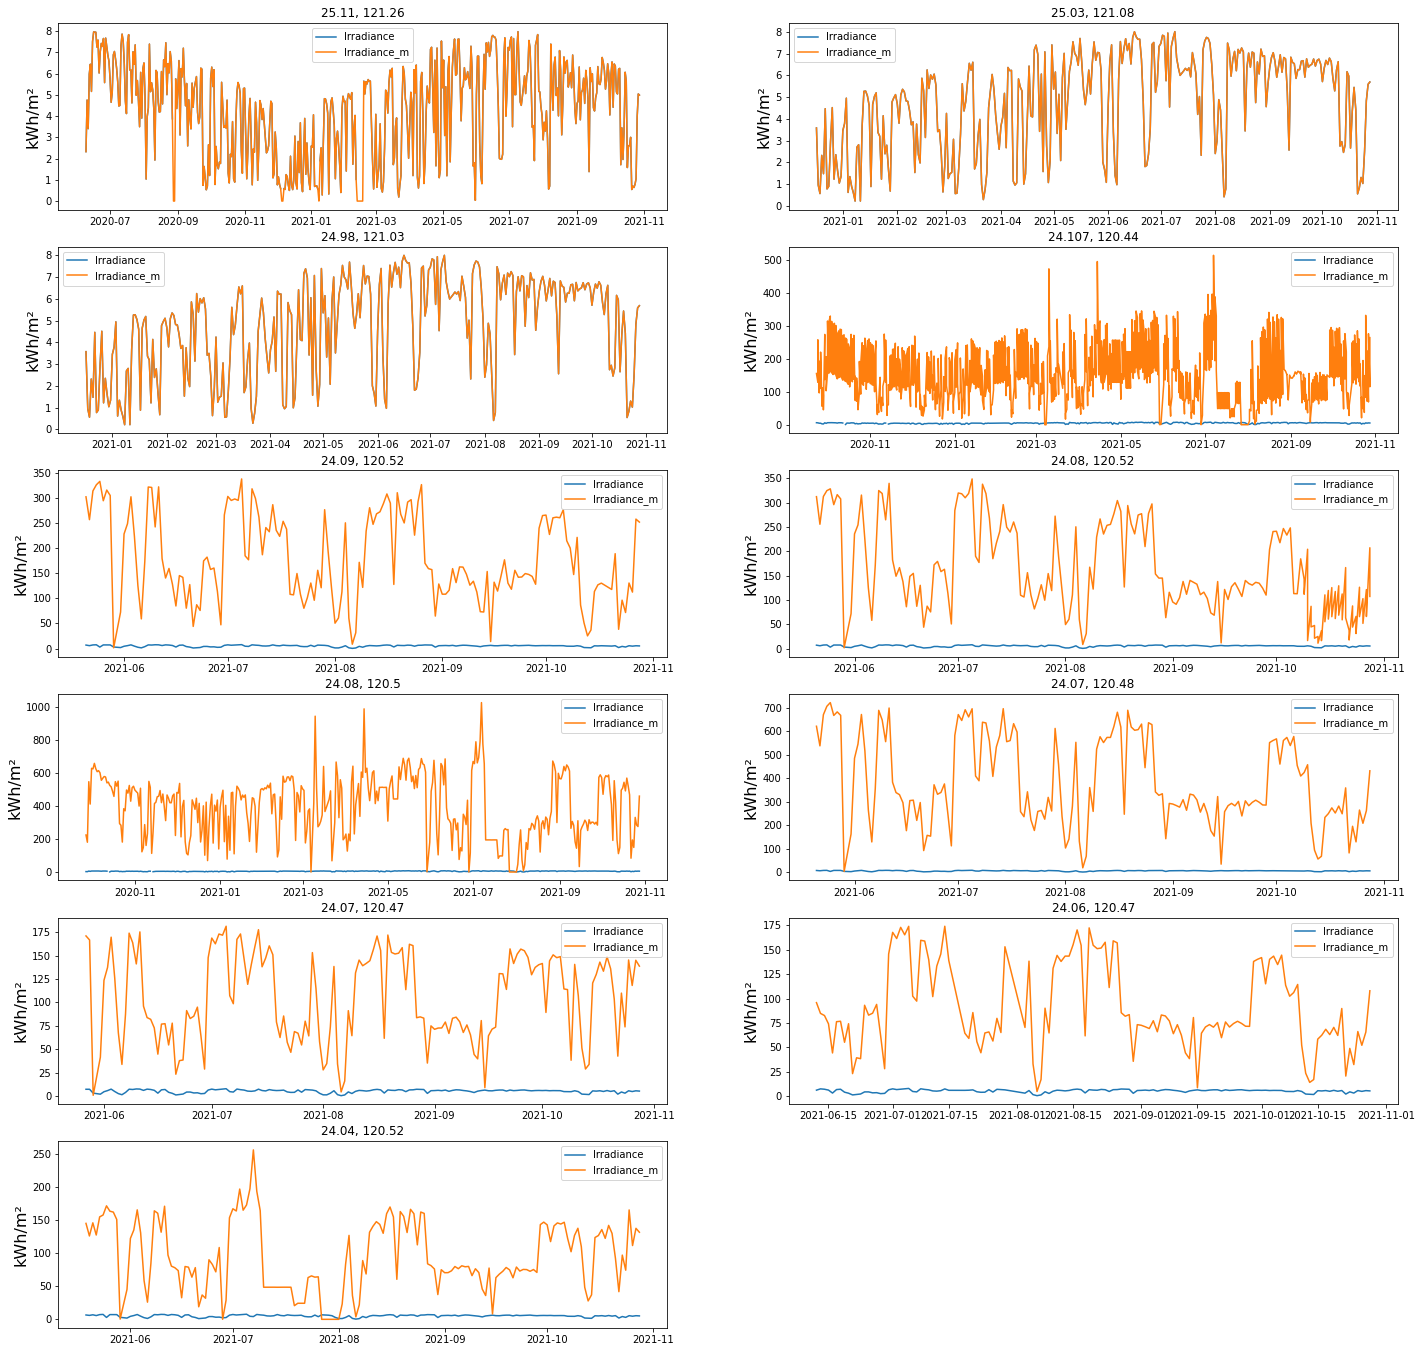

In [27]:
# drow Irradiance and Irradiance_m of each location
plt.figure(figsize=(24, 24))
for i, row in train_counts_location.iterrows():
    plt.subplot(math.ceil(len(train_counts_location)/2), 2, i+1)
    idf = train[train['Lat'].eq(row['Lat']) & train['Lon'].eq(row['Lon'])]
    plt.title(f"{row['Lat']}, {row['Lon']}")
    plt.plot(idf['Date'], idf['Irradiance'], label='Irradiance')
    plt.plot(idf['Date'], idf['Irradiance_m'], label='Irradiance_m')
    plt.ylabel('kWh/m²', fontsize=16)
    plt.legend() 


## Test

In [100]:
test = pd.read_csv(os.path.join(path, 'data/test.csv'))
test['Generation'] = 0.0
test = data_preprocessing(test)
test[['Lat', 'Lon', 'Temp', 'Temp_m', 'Irradiance', 'Irradiance_m', 'Generation', 'Capacity', 'CapacityFactor', 'ArrayRatio', 'ArrayRatio_m']].describe()

,Lat,Lon,Temp,Temp_m,Irradiance,Irradiance_m,Generation,Capacity,CapacityFactor,ArrayRatio,ArrayRatio_m
count,1539.000000,1539.000000,1356.000000,1099.000000,1539.000000,1539.000000,1539.0,1539.000000,1539.0,1539.0,1539.0
mean,24.358381,120.680032,18.863422,31.712011,3.378431,113.914567,0.0,335.654321,0.0,0.0,0.0
std,0.444123,0.309303,3.349447,8.832432,1.399051,124.256036,0.0,132.486180,0.0,0.0,0.0
min,24.040000,120.440000,12.300000,13.800000,0.261111,0.004000,0.0,99.200000,0.0,0.0,0.0
25%,24.070000,120.470000,16.600000,25.100000,2.277778,4.375000,0.0,267.520000,0.0,0.0,0.0
50%,24.080000,120.520000,18.000000,31.000000,3.866667,89.575000,0.0,314.880000,0.0,0.0,0.0
75%,24.980000,121.030000,20.700000,37.800000,4.525000,148.808000,0.0,492.800000,0.0,0.0,0.0
max,25.110000,121.260000,28.000000,60.100000,5.611111,528.400000,0.0,499.800000,0.0,0.0,0.0


In [101]:
test_counts_module_capacity_location = test.groupby(['Module', 'Lat', 'Lon', 'Angle', 'Capacity']).mean(
    ).reset_index().sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
test_counts_module_capacity_location[['Lat', 'Lon', 'Angle', 'Module', 'Capacity', 'CapacityFactor','ArrayRatio']]
# train_counts_module_capacity_location[['Lat', 'Lon', 'Angle', 'Module', 'Capacity', 'CapacityFactor','ArrayRatio']].to_csv(os.path.join(path, 'data/train_counts_module_capacity_location.csv'), index=False)

,Lat,Lon,Angle,Module,Capacity,CapacityFactor,ArrayRatio
0,25.110,121.26,-160.00,MM60-6RT-300,438.30,0.0,0.0
1,25.110,121.26,22.00,MM60-6RT-300,499.80,0.0,0.0
2,25.030,121.08,-95.00,MM60-6RT-300,498.60,0.0,0.0
3,24.980,121.03,-31.00,SEC-6M-60A-295,283.20,0.0,0.0
4,24.107,120.44,4.63,AUO PM060MW3 320W,246.40,0.0,0.0
5,24.107,120.44,4.63,AUO PM060MW3 320W,492.80,0.0,0.0
6,24.090,120.52,0.00,AUO PM060MW3 320W,278.40,0.0,0.0
7,24.080,120.52,-2.13,AUO PM060MW3 320W,267.52,0.0,0.0
8,24.080,120.52,-2.62,AUO PM060MW3 325W,343.20,0.0,0.0
9,24.080,120.50,1.76,AUO PM060MW3 320W,99.20,0.0,0.0


In [106]:
def apply_generation_by_array_ratio_with_lat_lon_module_capacity(row, refs):
    mask = refs['Lat'].eq(row['Lat']) & refs['Lon'].eq(row['Lon']) & refs['Module'].eq(row['Module']) & refs['Capacity'].eq(row['Capacity'])
    ref = refs[mask]
    if(len(ref)==1):
        return row['Irradiance'] * row['Capacity'] * ref.iloc[0]['ArrayRatio']
    else:
        print('fuck')
        return 0.0

In [107]:
test['Generation'] = test.apply(lambda row: apply_generation_by_array_ratio_with_lat_lon_module_capacity(row, train_counts_module_capacity_location), axis=1)

'2022-06-12 00:02:20'

In [115]:
nowDate = datetime.now().strftime("%Y-%m-%d,%H-%M-%S")
test[['ID','Generation']].to_csv(os.path.join(path, f'submission/test_generation({nowDate}).csv'), index=False)